<a href="https://colab.research.google.com/github/sohampalande/Solar-Energy-Nowcasting/blob/main/modeltest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
import keras.backend as K
from tensorflow import keras
import os
import numpy as np
import pylab as plt
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.backend import clip 
import math


# Define Model Architecture

In [2]:
"""
3-layer stacked ConvLSTM2D Encoder-Decoder
"""

def define_models_clouds(n_filter, filter_size):
    # define training encoder
    encoder_inputs = Input(shape=(None, 101, 101, 1))
    encoder_1 = ConvLSTM2D(filters = n_filter, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    encoder_2 = ConvLSTM2D(filters = 32, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    encoder_3 = ConvLSTM2D(filters = 32, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    encoder_outputs_1, encoder_state_h_1, encoder_state_c_1 = encoder_1(encoder_inputs)
    encoder_outputs_2, encoder_state_h_2, encoder_state_c_2 = encoder_2(encoder_outputs_1)
    encoder_outputs_3, encoder_state_h_3, encoder_state_c_3 = encoder_3(encoder_outputs_2)
    # define training decoder
    decoder_inputs = Input(shape=(None, 101, 101, 1))
    decoder_1 = ConvLSTM2D(filters=n_filter, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    decoder_2 = ConvLSTM2D(filters=32, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    decoder_3 = ConvLSTM2D(filters=32, kernel_size=filter_size, activation='relu', padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    decoder_outputs_1, _, _ = decoder_1([decoder_inputs, encoder_state_h_1, encoder_state_c_1])
    decoder_outputs_2, _, _ = decoder_2([decoder_outputs_1, encoder_state_h_2, encoder_state_c_2])
    decoder_outputs_3, _, _ = decoder_3([decoder_outputs_2, encoder_state_h_3, encoder_state_c_3])
    decoder_conv3d = Conv3D(filters=1, kernel_size=(1,1,32), activation='relu', padding='same', data_format='channels_last',
                            kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))
    decoder_outputs = decoder_conv3d(decoder_outputs_3)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #print(model.summary(line_length=250))
    # define inference encoder
    encoder_model = Model(encoder_inputs, 
                          [encoder_state_h_1, encoder_state_c_1, encoder_state_h_2, encoder_state_c_2, encoder_state_h_3, encoder_state_c_3])
    
    # define inference decoder
    decoder_state_input_h_1 = Input(shape=(101,101,n_filter))
    decoder_state_input_c_1 = Input(shape=(101,101,n_filter))
    decoder_state_input_h_2 = Input(shape=(101,101,32))
    decoder_state_input_c_2 = Input(shape=(101,101,32))
    decoder_state_input_h_3 = Input(shape=(101,101,32))
    decoder_state_input_c_3 = Input(shape=(101,101,32))
    decoder_output_1, decoder_state_h_1_new, decoder_state_c_1_new = decoder_1([decoder_inputs, decoder_state_input_h_1, decoder_state_input_c_1])
    decoder_output_2, decoder_state_h_2_new, decoder_state_c_2_new = decoder_2([decoder_output_1, decoder_state_input_h_2, decoder_state_input_c_2])
    decoder_output_3, decoder_state_h_3_new, decoder_state_c_3_new = decoder_3([decoder_output_2, decoder_state_input_h_3, decoder_state_input_c_3])
    decoder_output = decoder_conv3d(decoder_output_3)
    decoder_model = Model([decoder_inputs , decoder_state_input_h_1 , decoder_state_input_c_1, decoder_state_input_h_2 , decoder_state_input_c_2, 
                           decoder_state_input_h_3 , decoder_state_input_c_3],
                          [decoder_output, decoder_state_h_1_new, decoder_state_c_1_new, decoder_state_h_2_new, decoder_state_c_2_new, 
                           decoder_state_h_3_new, decoder_state_c_3_new])
    
    return model, encoder_model, decoder_model

## Import Data

In [3]:
data = np.load('/content/drive/My Drive/Aresty2020-2021/training_data.npy', encoding='bytes')
print(data.shape)

test = np.load('/content/drive/My Drive/Aresty2020-2021/test_data.npy', encoding='bytes')
print(test.shape)

(516, 15, 101, 101, 1)
(1, 15, 101, 101, 1)


Reshape 

In [4]:
X1 = data[:,:8,:,:,:]
print(X1.shape)

tem = np.zeros((516,1,101,101,1))
tem = tem.astype(int)

X2 = np.concatenate((tem, data[:,8:14,:,:,:]), axis=1)
X2 = X2.astype('uint8')
print(X2.shape)


y = data[:,8:15,:,:,:]
print(y.shape)

(516, 8, 101, 101, 1)
(516, 7, 101, 101, 1)
(516, 7, 101, 101, 1)


# Training


##First/initial Train

Set Callbacks


In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Adding another callback to save model after every epoch in training

checkpoint_filepath='/content/drive/My Drive/Aresty2020-2021/saved_model/weights.{epoch:02d}-{val_loss:.2f}'

csv_logger = CSVLogger('/content/drive/MyDrive/Aresty2020-2021/saved_model/traininglog.csv', separator=',', append=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


Train the Model

In [6]:
train_model, infenc_model, infdec_model = define_models_clouds(n_filter=64, filter_size=3)

train_model.compile(loss='mse', optimizer='adam', metrics=['mae'])



history_model = train_model.fit([X1, X2],
                                y, batch_size=8, validation_split=0.25, epochs=8, callbacks=[es,model_checkpoint_callback,csv_logger])

Epoch 1/35
49/49 [==============================] - 4227s 86s/step - loss: 5470.5309 - mae: 50.7612 - val_loss: 531.7573 - val_mae: 16.3560
INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/weights.01-531.76/assets
Epoch 2/35
49/49 [==============================] - 4200s 86s/step - loss: 439.9005 - mae: 14.5411 - val_loss: 285.3994 - val_mae: 11.2858
INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/weights.02-285.40/assets
Epoch 3/35
49/49 [==============================] - 4202s 86s/step - loss: 257.0692 - mae: 10.4894 - val_loss: 246.1789 - val_mae: 10.5955
INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/weights.03-246.18/assets
Epoch 4/35
49/49 [==============================] - 4208s 86s/step - loss: 211.3476 - mae: 9.2722 - val_loss: 185.9029 - val_mae: 8.5822
INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/weights.04-185.90/asse

KeyboardInterrupt: ignored

Save infenc_model and infdec_model 


In [7]:
infenc_model.save('/content/drive/My Drive/Aresty2020-2021/saved_model/infenc_model1')
infdec_model.save('/content/drive/My Drive/Aresty2020-2021/saved_model/infdec_model1')


INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/infenc_model1/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Aresty2020-2021/saved_model/infdec_model1/assets


## Retrain/Continue Training
(run everything until first train)

In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Adding another callback to save model after every epoch in training

checkpoint_filepath='/content/drive/My Drive/Aresty2020-2021/saved_model/weights.{epoch:02d}-{val_loss:.2f}'

csv_logger = CSVLogger('/content/drive/MyDrive/Aresty2020-2021/saved_model/traininglog.csv', separator=',', append=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

new_model, infenc_model, infdec_model = define_models_clouds(n_filter=64, filter_size=3)



Load Model - To resume training

In [6]:
#might have to update part after saved_model manually
#since we're using load_model instead of load_weights, we do not have to use intial_epoch as an argument in newmodel.fit since it resumes from there by default  
#change names of files to load as required
#do NOT compile model!

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Aresty2020-2021/saved_model/weights.08-132.37')

infenc_model=tf.keras.models.load_model('/content/drive/MyDrive/Aresty2020-2021/saved_model/infenc_model1')

infdec_model=tf.keras.models.load_model('/content/drive/MyDrive/Aresty2020-2021/saved_model/infdec_model1')


Continue Training (need to experiment)

In [ ]:
#change initial epoch
#inital epoch is how many epochs you have finished training for
new_model.fit([X1, X2],
                y, batch_size=8, validation_split=0.25, epochs=16, callbacks=[es,model_checkpoint_callback], initial_epoch=8)

Epoch 9/16
29/49 [================>.............] - ETA: 24:56 - loss: 1231.7223 - mae: 21.8894

In [ ]:
#change filename before saving // or overwrite
infenc_model.save('/content/drive/My Drive/Aresty2020-2021/saved_model/infenc_model2')
infdec_model.save('/content/drive/My Drive/Aresty2020-2021/saved_model/infdec_model2')

##Plot Loss and Vaildation loss at each epoch

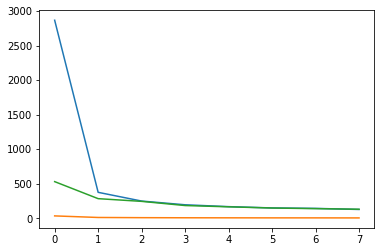

In [18]:
#Plot learning


#plt.plot(history_model.history['loss'])
#plt.plot(history_model.history['val_loss'])
#plt.title('3-layer convlstm model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()


#history_model.history['loss'][-5:]
#history_model.history['val_loss'][-5:]
#history_model.history['mean_absolute_error'][-5:]
#history_model.history['val_mean_absolute_error'][-5:]
data = np.genfromtxt('/content/drive/MyDrive/Aresty2020-2021/saved_model/traininglog.csv', delimiter=",", names=["epoch", "loss","mae","val_loss","val_mae"])
plt.plot(data['epoch'], data['loss'])
plt.plot(data['epoch'], data['mae'])
plt.plot(data['epoch'], data['val_loss'])
#plt.plot(data['epoch'], data['val_mae'])



# Test Sequence and Visualize

Define Predict Function


*   Input: Sequence of 8 images
*   Output: 7 image sequence



In [9]:
# generate target given source sequence
def predict_sequence_3(infenc, infdec, source, n_steps):
	# encode
	state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = infenc.predict(source)  # source_dim = ()
#	decoder_input = source[:,-1,:,:,:].reshape((1,1,64,64,1))
	decoder_input = np.repeat(0,101*101).reshape((1,1,101,101,1))
	# collect predictions
	output = list()
	for t in range(n_steps):
		# predict next char
		yhat, h_1, c_1, h_2, c_2, h_3, c_3 = infdec.predict([decoder_input, state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3])
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = h_1, c_1, h_2, c_2, h_3, c_3
		# update target sequence
		decoder_input = yhat
	return np.array(output)

Make prediction on 1 testing sample

In [10]:
#Test
#test on last set of images

track=test[0,:8,:,:,:]
history = track[np.newaxis, ::, ::, ::, ::]
history.shape

prediction_3 = predict_sequence_3(infenc_model, infdec_model, history, 7)



Visualize

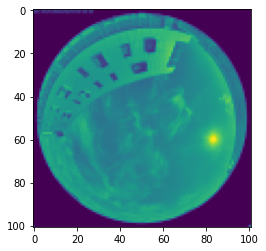

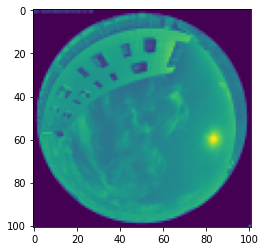

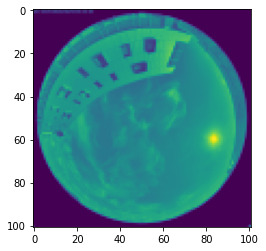

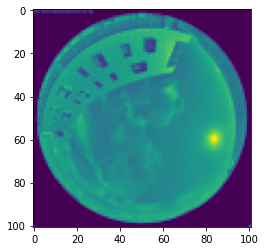

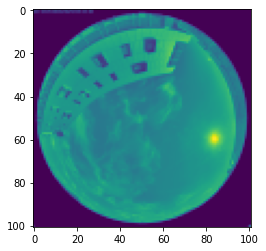

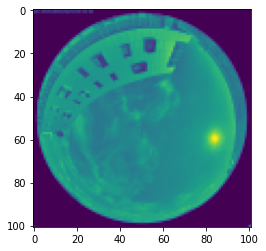

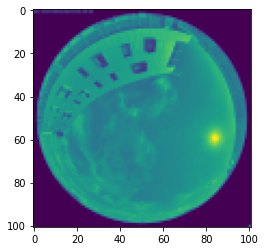

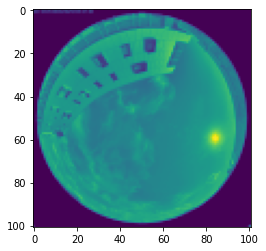

#################################################################
7 Step Prediction


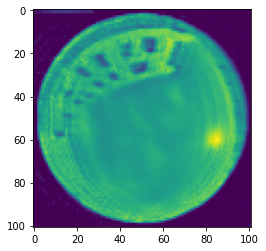

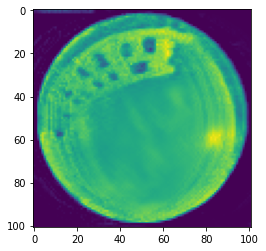

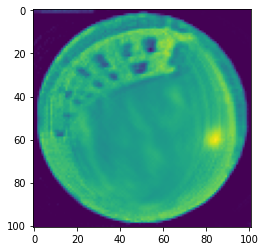

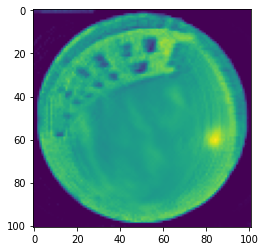

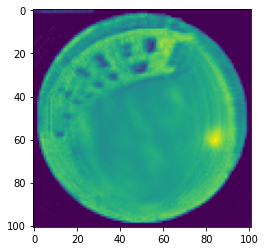

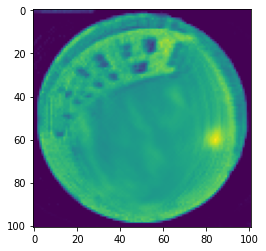

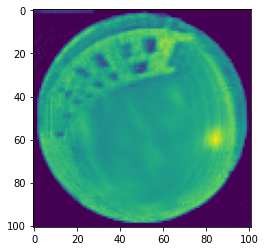

#################################################################
True Values


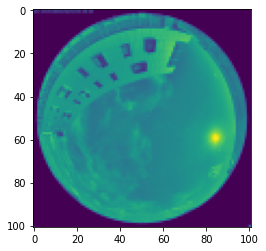

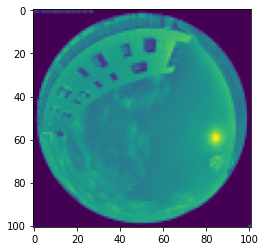

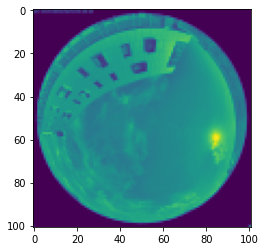

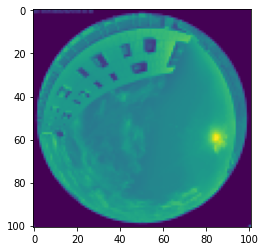

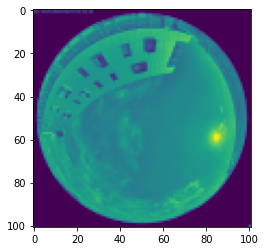

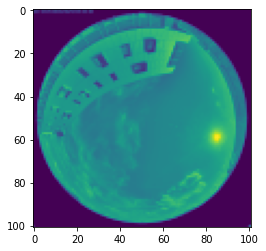

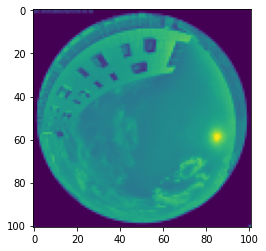

In [13]:
#Plot/Visuailze
#fig = plt.figure(figsize=(15,1))

for i in range(8):
  toplot=track[i,:,:,0]
  plt.imshow(toplot)
  plt.show()

print("#################################################################")
print("7 Step Prediction")

for i in range(7):
    #ax = fig.add_subplot(6,7,i+1)
    #toplot = track[i, ::, ::, 0]
    #plt.imshow(toplot)
    
    #*ax = fig.add_subplot(6,7,i+8)
    #*toplot = track[i+7, ::, ::, 0]
    #*plt.imshow(toplot)
    
    #ax = fig.add_subplot(6,7,i+15)
    #toplot = prediction_lstm[i, ::, ::, 0]
    #plt.imshow(toplot)
    
    #ax = fig.add_subplot(6,7,i+22)
    #toplot = prediction_1[i, ::, ::, 0]
    #plt.imshow(toplot)
    
    #ax = fig.add_subplot(6,7,i+29)
    #toplot = prediction_2[i, ::, ::, 0]
    #plt.imshow(toplot)
    
    #ax = fig.add_subplot(6,7,i+36)
    toplot = prediction_3[i, ::, ::, 0]
    plt.imshow(toplot)
    plt.show()

print("#################################################################")
print("True Values")
track2=test[0,:,:,:,:]
for i in range(8,15):
  toplot=track2[i,:,:,0]
  plt.imshow(toplot)
  plt.show()
